In [1]:
# Basic Imports and Data Setup

import math
import numpy as np
import scipy
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline 
import sklearn.preprocessing
from sklearn.utils import shuffle

mnist = scipy.io.loadmat("./hw6_data_dist/letters_data.mat")

mnist_train_data = mnist["train_x"]
#mnist_train_labels = mnist["train_y"] # 1 - 26
mnist_test_data = mnist["test_x"]
mnist_raw_labels = mnist["train_y"]

#Append bias to training data
#ones = np.array([[1 for _ in range(len(mnist_train_data))]])
#mnist_train_data_augmented = np.concatenate((mnist_train_data, ones.T), axis=1)

mnist_train_data, mnist_raw_labels = shuffle(
    mnist_train_data, mnist_raw_labels, random_state=0)

mnist_train_data = sklearn.preprocessing.scale(mnist_train_data)
mnist_test_data = sklearn.preprocessing.scale(mnist_test_data)

logging = False

def logprint(msg):
    if logging:
        print(msg)
        
#print(mnist_train_data[0])
print(len(mnist_train_data))

c:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


124800


[23]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
e


c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


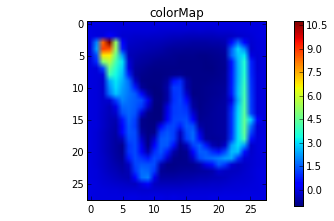

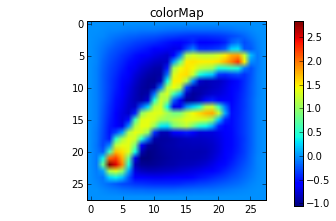

In [108]:
# Data Preprocessing

def labelsToVector(labels):
    result = []
    for label in labels:
        vec = [1 if i+1 == label else 0 for i in range(26)]
        result.append(vec)
    return result

mnist_train_labels = labelsToVector(mnist_raw_labels)


print(mnist_raw_labels[100])
print(mnist_train_labels[100])

def visualize(data):

    fig = plt.figure(figsize=(6, 3.2))

    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    plt.imshow(data.reshape((28,28)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()
    
numToLetter = {}
    
for x, y in ((x + 1, chr(ord('a') + x)) for x in range(26)):
    numToLetter[x] = y
    
print(numToLetter[5])
    
    
visualize(mnist_train_data[100])
visualize(mnist_train_data[101])

In [139]:
# Main training of the network by SGD

#Note that this works for matrices by element
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#z is predicted, y is actual
def crossEntropy(z, y):
    assert len(z) == len(y)
    entropy = 0
    for j in range(len(z)):
        entropy += y[j] * np.log(z[j]) + (1 - y[j]) * np.log(1 - z[j])
    return -entropy    

entropy_data = []
accuracy_data = []

def trainNeuralNetwork(images, labels, iterations = 10, learning_rate = 0.01, trainOnNumImages = None, learning_rate_falloff = 0.75, printTrainLoss = False):
    if trainOnNumImages is None:
        trainOnNumImages = len(images)
    
    #V = np.random.rand(200, 785)
    #W = np.random.rand(26, 201)
    
    #V = np.random.normal(0, math.sqrt(1/785), (200,785))
    #W = np.random.normal(0, math.sqrt(1/201), (26,201))
    
    V = np.random.normal(0, 0.1, (200,785))
    W = np.random.normal(0, 0.1, (26,201))
    
    """
    for r in range(200):
        V[r][784] = 1
    for r in range(26):
        W[r][200] = 1
    """
        
    zeros = np.zeros(shape=(26,1))   
    v_zeros = np.zeros(shape=(200,1))
        
    iterationsDone = 0  
    while iterations > 0:
        #Choose a random index for SGD, we'll use this to update
        logprint("Start, first multiplications")
        
        index = int(np.random.random() * trainOnNumImages)
        X_i = images[index] #The data
        y_i = labels[index] #The correct value as a vector
        X_augmented = np.concatenate((X_i, np.array([1])))
        
        #Compute the forward pass by simple matrix multiplication
        #hidden = V * X_i
        #200 x 1 = 200 x 785 * 785 x 1
        hidden = np.dot(V, X_augmented)
        hidden_activated = np.tanh(hidden)
        #V 201 x 1
        hidden_activated_bias = np.concatenate((hidden_activated, np.array([1])))
        
        logprint("Second multiplication")
        
        #output = W * hidden_bias
        #26 x 1 = 26 x 201 * 201 x 1
        output = np.dot(W, hidden_activated_bias)
        output_activated = sigmoid(output)
        
        entropy = crossEntropy(output_activated, y_i)
        
        if printTrainLoss:
            print(output_activated)
            print("Predicted in SGD for index " + str(index) + ", predicted " + str(findPrediction(output_activated)))
            print("True value: " + str(findPrediction(y_i)))
            count = 0
            predictions = predictNeuralNetwork(mnist_train_data[0:trainOnNumImages], V, W)
            for i in range(len(predictions)):
                if str(findPrediction(predictions[i])) == str(mnist_raw_labels[i][0]):
                    count += 1
            print("Training Accuracy: " + str(float(count)/float(len(predictions))))
            print("Entropy: " + str(entropy))
            print("------------------")
        
        #SGD
        
        #V_copy = np.array(V)
        #W_copy = np.array(W)
        
        derivatives_store = np.ndarray(shape=(26,1))
        
        logprint("Precompute derivatives")
        
        for outputIndex in range(len(output)):
            left = - y_i[outputIndex] / output_activated[outputIndex]
            left += (1 - y_i[outputIndex]) / (1 - output_activated[outputIndex])
            middle = output_activated[outputIndex] * (1 - output_activated[outputIndex])
            derivatives_store[outputIndex] = (left * middle * learning_rate)
        
        logprint("Hidden-output weight calculations")
        
        """
        for outputIndex in range(len(output)): #for every unit in the output layer
            leftmiddle = derivatives_store[outputIndex]
            for hiddenIndex in range(len(hidden)):
                #left = - y_i[outputIndex] / output_activated[outputIndex] + (1 - y_i[outputIndex]) / (1 - output_activated[outputIndex])
                #middle = output_activated[outputIndex] * (1 - output_activated[outputIndex])
                right = hidden_activated[hiddenIndex]
                d_e_weight = leftmiddle * right
                W_copy[outputIndex][hiddenIndex] -= learning_rate * d_e_weight
        """
        
        #derivatives_store = np.transpose(np.array([derivatives_store]))
        W_update = np.dot(derivatives_store, np.array([hidden_activated_bias]))
        
        #W_update = np.dot(W_update, learning_rate)
        #W_update = np.concatenate((W_update, zeros), axis=1)
        
        logprint("Input-hidden weight calculations")
        
        derivatives_store_2 = np.ndarray(shape=(len(hidden_activated),1))
        
        hiddenDerivative = np.ndarray(shape=(200,1))
        for hiddenIndex in range(len(hidden_activated)):
            hiddenDerivative[hiddenIndex] = 1 - hidden_activated[hiddenIndex]*hidden_activated[hiddenIndex]
        
        """
        for hiddenIndex in range(len(hidden_activated)):
            sum_outgoing = 0
            middle = 1 - hidden_activated[hiddenIndex]*hidden_activated[hiddenIndex]
            
            for outputIndex in range(26):
                sum_outgoing += derivatives_store[outputIndex] * W[outputIndex][hiddenIndex]
                #temp[outputIndex][hiddenIndex] = derivatives_store[outputIndex] * W[outputIndex][hiddenIndex]
                
            #leftmiddle = sum_outgoing * middle
            #derivatives_store_2[hiddenIndex] = sum_outgoing * middle
            
            leftmiddle = sum_outgoing * middle
            
            for inputIndex in range(len(X_i)):
                right = X_i[inputIndex]
                d_e_weight = leftmiddle * right
                V_copy[hiddenIndex][inputIndex] -= learning_rate * d_e_weight
        """
            
        result = np.dot(np.transpose(W), derivatives_store)
        result = np.delete(result, 200, 0)
        derivatives_store_2 = np.multiply(result, hiddenDerivative)
        
        V_update = np.dot(derivatives_store_2, np.array([X_augmented]))
        
        #V_update = np.concatenate((V_update, v_zeros), axis=1)
        
        if iterations % 10000 == 0:
            print("Iterations left: " + str(iterations) + ", entropy: " + str(entropy))
            
        if iterations % 1000 == 0:
            #print(entropy_data)
            entropy_data.append(entropy)
            
            predictions = predictNeuralNetwork(images[0:1000], V, W)
            count = 0
            for i in range(len(predictions)):
                logprint(str(findPrediction(predictions[i]) + 1) + ": " + str(mnist_raw_labels[i]))
                if str(findPrediction(predictions[i]) + 1) == str(mnist_raw_labels[i][0]):
                    count += 1
                #print(str(predictions[i]) + " " + str(findPrediction(predictions[i])) + ": " + str(mnist_raw_labels[i]))
            
            accuracy_data.append(count/len(predictions))
        
        #Do some gradient checking
        
        W = np.subtract(W, W_update)
        V = np.subtract(V, V_update)
        
        #print("-----")
        
        iterations -= 1
        iterationsDone += 1
        
        if iterationsDone % trainOnNumImages == 0 and iterationsDone != 0:
            learning_rate *= learning_rate_falloff
        
        #matrixResult = np.subtract(V, V_update)
        
        #V = V_copy
        #W = W_copy
        
        #print("-----")
        #print(matrixResult)
        #print(V_copy)
        #print(np.subtract(matrixResult, V_copy))

    return V, W



In [140]:
checkLen = 100000
iterations = 300000
learning_rate = 0.022 
learning_decay = 0.8

logging = False
checkV, checkW = trainNeuralNetwork(mnist_train_data, mnist_train_labels, iterations, learning_rate, checkLen, learning_decay, False)

predictions = predictNeuralNetwork(mnist_train_data[0:checkLen], checkV, checkW)

count = 0
for i in range(len(predictions)):
    logprint(str(findPrediction(predictions[i]) + 1) + ": " + str(mnist_raw_labels[i]))
    if str(findPrediction(predictions[i]) + 1) == str(mnist_raw_labels[i][0]):
        count += 1
        
    #print(str(predictions[i]) + " " + str(findPrediction(predictions[i])) + ": " + str(mnist_raw_labels[i]))

print("Training Accuracy: " + str(count/len(predictions)))

Iterations left: 300000, entropy: 21.9524676238
Iterations left: 290000, entropy: 0.255503567924
Iterations left: 280000, entropy: 2.23449151846
Iterations left: 270000, entropy: 0.0838306253674
Iterations left: 260000, entropy: 1.79838144498
Iterations left: 250000, entropy: 0.391057999121
Iterations left: 240000, entropy: 0.122560982699
Iterations left: 230000, entropy: 3.03081858208
Iterations left: 220000, entropy: 0.296911636165
Iterations left: 210000, entropy: 0.116194395192
Iterations left: 200000, entropy: 0.678082620193
Iterations left: 190000, entropy: 0.249702412983
Iterations left: 180000, entropy: 0.413104658908
Iterations left: 170000, entropy: 8.68448434629
Iterations left: 160000, entropy: 0.473287300278
Iterations left: 150000, entropy: 7.48341340547
Iterations left: 140000, entropy: 1.23144411004
Iterations left: 130000, entropy: 10.294316936
Iterations left: 120000, entropy: 0.164000227643
Iterations left: 110000, entropy: 0.259603853042
Iterations left: 100000, ent

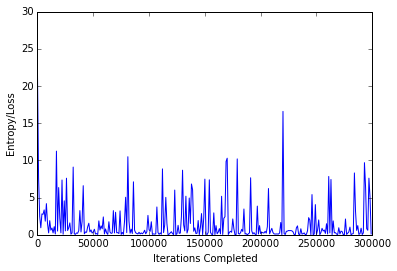

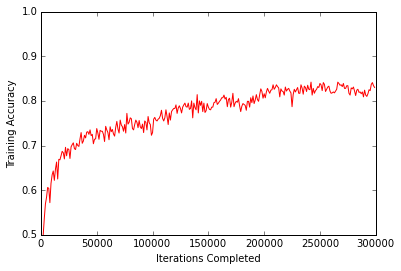

In [142]:
xData = [i for i in range(0,300000,1000)]

plt.plot(xData, entropy_data, 'b-')
plt.axis([0, 300000, 0, 30])
plt.xlabel('Iterations Completed')
plt.ylabel('Entropy/Loss')
plt.show()

plt.plot(xData, accuracy_data, 'r-')
plt.axis([0, 300000, 0.5, 1])
plt.xlabel('Iterations Completed')
plt.ylabel('Training Accuracy')
plt.show()

In [98]:
checkLen = 30
iterations = 90
learning_rate = 0.02

logging = False

for learning_rate in np.arange(0.020, 0.030, 0.001):
    for learning_decay in np.arange(0.7, 1.01, 0.05):
        accuracy = 0
        for _ in range(10):
            checkTestV, checkTestW = trainNeuralNetwork(mnist_train_data, mnist_train_labels, iterations, learning_rate, checkLen, learning_decay, False)

            predictions = predictNeuralNetwork(mnist_train_data[0:checkLen], checkTestV, checkTestW)

            count = 0
            for i in range(len(predictions)):
                logprint(str(findPrediction(predictions[i]) + 1) + ": " + str(mnist_raw_labels[i]))
                if str(findPrediction(predictions[i]) + 1) == str(mnist_raw_labels[i][0]):
                    count += 1
                #print(str(predictions[i]) + " " + str(findPrediction(predictions[i])) + ": " + str(mnist_raw_labels[i]))
            
            accuracy += count/len(predictions)
        print("Training Accuracy: " + str(accuracy/10.0) + ", Learning Rate/Decay: " + str(learning_rate) + " " + str(learning_decay))
    print("-----------")

Training Accuracy: 0.9366666666666668, Learning Rate/Decay: 0.02 0.7
Training Accuracy: 0.9233333333333335, Learning Rate/Decay: 0.02 0.75
Training Accuracy: 0.9533333333333334, Learning Rate/Decay: 0.02 0.8
Training Accuracy: 0.93, Learning Rate/Decay: 0.02 0.85
Training Accuracy: 0.93, Learning Rate/Decay: 0.02 0.9
Training Accuracy: 0.9100000000000001, Learning Rate/Decay: 0.02 0.95
Training Accuracy: 0.9133333333333334, Learning Rate/Decay: 0.02 1.0
-----------
Training Accuracy: 0.9200000000000002, Learning Rate/Decay: 0.021 0.7
Training Accuracy: 0.9333333333333333, Learning Rate/Decay: 0.021 0.75
Training Accuracy: 0.9433333333333334, Learning Rate/Decay: 0.021 0.8
Training Accuracy: 0.9400000000000002, Learning Rate/Decay: 0.021 0.85
Training Accuracy: 0.9666666666666668, Learning Rate/Decay: 0.021 0.9
Training Accuracy: 0.9233333333333335, Learning Rate/Decay: 0.021 0.95
Training Accuracy: 0.9400000000000001, Learning Rate/Decay: 0.021 1.0
-----------
Training Accuracy: 0.9233

KeyboardInterrupt: 

True class was a, but we predicted z


c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


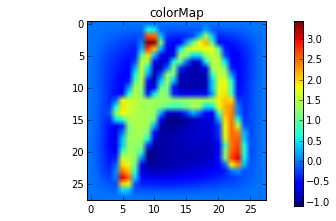

---------------
True class was g, but we predicted q


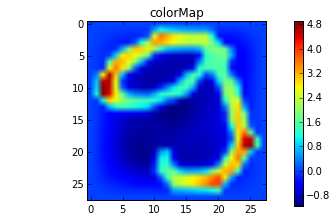

---------------
True class was z, but we predicted a


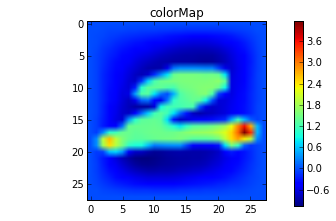

---------------
True class was n, but we predicted x


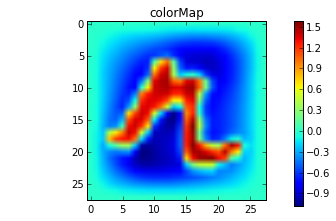

---------------
True class was b, but we predicted d


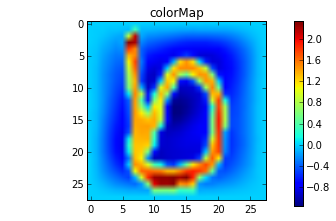

---------------
Training Validation Accuracy: 0.91767


In [116]:
indices = [i for i in range(0,checkLen)]
validationPred = predictNeuralNetwork(mnist_train_data[indices], checkV, checkW)

count = 0

numToVisualize = 5

for i in range(len(indices)):
    index = indices[i]
    #print(str(findPrediction(validationPred[i]) + 1) + ": " + str(mnist_raw_labels[index]))
    if str(findPrediction(validationPred[i]) + 1) == str(mnist_raw_labels[index][0]):
        count += 1
    elif numToVisualize > 0:
        numToVisualize -= 1
        print("True class was " + numToLetter[mnist_raw_labels[index][0]] + ", but we predicted " + numToLetter[findPrediction(validationPred[i]) + 1])
        print()
        visualize(mnist_train_data[index])
        print("---------------")
    
print("Training Validation Accuracy: " + str(count/len(indices)))

In [100]:
testPred = predictNeuralNetwork(mnist_test_data, checkV, checkW)

results = []
for i in range(len(testPred)):
    results.append([i+1, findPrediction(testPred[i]) + 1])
temp = np.asarray(results)
np.savetxt("submission_neural_letters.csv", temp, fmt="%i,%i", delimiter=",", header="Id,Category")

In [4]:
def findPrediction(prediction):
    maxIndex = -1
    maxIndexScore = 0
    for i in range(len(prediction)):
        if prediction[i] > maxIndexScore or maxIndex == -1:
            maxIndex = i
            maxIndexScore = prediction[i]
    return maxIndex

def predictNeuralNetwork(images, V, W):
    predictions = []
    for index in range(len(images)):
        prediction = calculateVal(images[index], V, W)
        predictions.append(prediction)
    return predictions
    
def calculateVal(X_i, V, W):    
    #Compute the forward pass by simple matrix multiplication
    #hidden = V * X_i
    #200 x 1 = 200 x 785 * 785 x 1
    X_augmented = np.concatenate((X_i, np.array([1])))
    
    hidden = np.dot(V, X_augmented)
    hidden_activated = np.tanh(hidden)
    #V 201 x 1
    hidden_activated_bias = np.concatenate((hidden_activated, np.array([1])))

    #output = W * hidden_bias
    #26 x 1 = 26 x 201 * 201 x 1
    output = np.dot(W, hidden_activated_bias)
    output_activated = sigmoid(output)

    return output_activated
    

In [ ]:
predictions = predictNeuralNetwork(mnist_train_data, trainedV, trainedW)

for i in range(200):
    print(str(predictions[i]) + " " + str(findPrediction(predictions[i])) + ": " + str(mnist_raw_labels[i]))